In [ ]:
from utils.EventData import *
from utils.plot import Plotter, watermark, infotext

# Load MMC data

Load raw detector data from binary format and write to a pandas dataframe. If reload_binary set to False the data is read from a pre-processed pickle file instead.

In [ ]:
reload_binary= False
filename = 'spectrum_for_1p3eV'

ev_data = EventData('spectrum_for_1p3eV', reload_binary)
ev_data.raw

# Calculate basic pulse attributes

Calculate basic pulse attributes (also called reduced quantities) from the raw data

In [3]:
pulse_attr = ev_data.processed_df
pulse_attr

pulse_height  peak_arg  rising_arg  baseline_mean  baseline_std  \
TraceNo                                                                    
1        10395.033209      4462        4035     128.966791      5.497584   
2        10412.858240      4463        4035     131.341760      5.541054   
3        10488.187361      4466        4035     132.412639      5.665959   
4        10395.584139      4472        4035     128.615861      5.409171   
5        11399.376456      4469        4035     128.223544      5.560980   
...               ...       ...         ...            ...           ...   
8650     11382.579678      4441        4035     132.620322      5.723889   
8651     10396.366419      4492        4035     131.133581      5.443981   
8652     10396.139157      4464        4035     133.160843      5.542639   
8653     10393.080962      4496        4034     134.319038      5.461235   
8654     10409.698513      4450        4035     145.001487      5.693536   

         t_rising  
TraceNo            
1        0.026368  
2        0.026368  
3        0.026368  
4        0.026368  
5        0.026368  
...           ...  
8650     0.025856  
8651     0.026368  
8652     0.026368  
8653     0.026368  
8654     0.026368  

[8654 rows x 6 columns]

# Plot trace

Plot a single trace by ID. For plotting multiple traces at once use plot_traces() where you can also adjust the number of columns to plot to. 

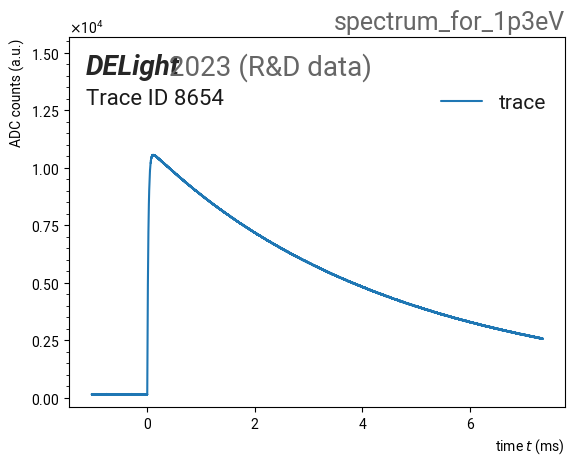

In [4]:
ev_data.plot_trace(8654)

# Template building

Build a trace template by selecting samples from the Kalpha1 peak and some additional filtering of these samples by self-cleaning in order to obtain appropriate samples for the template building. The template is then built by averaging over the selected samples

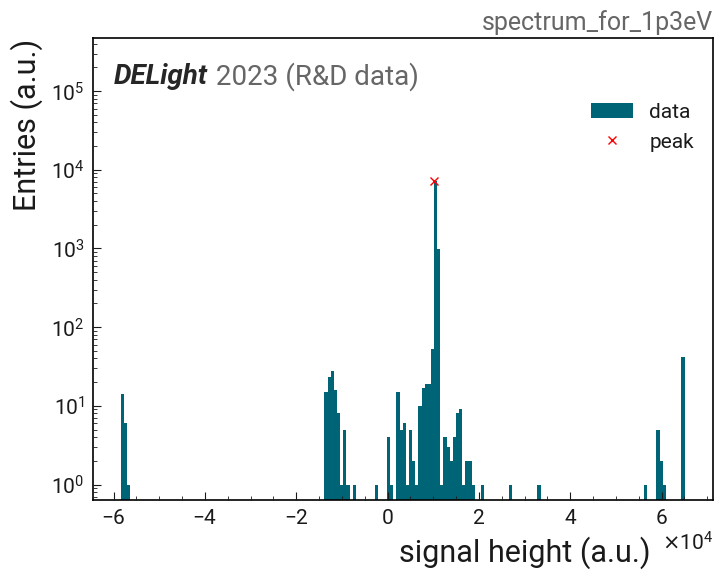

156 traces from peak used for template building
template saved to template/template.npy


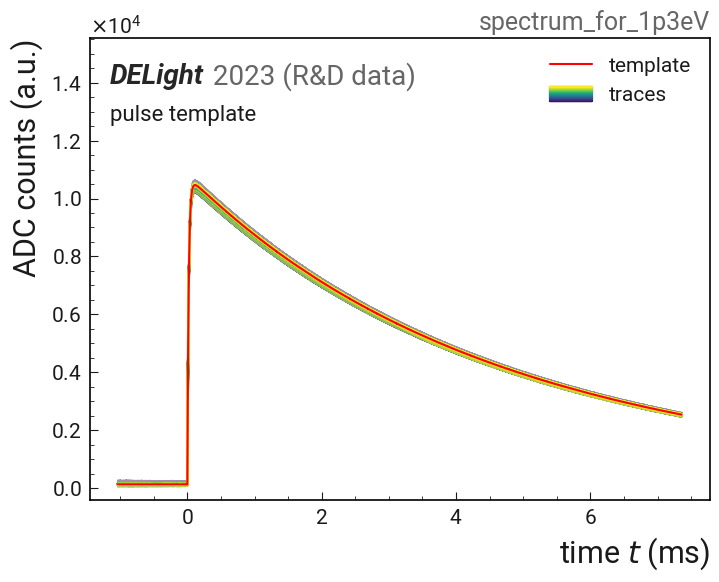

In [5]:
template = ev_data.build_template(tolerance=0.02, 
                                  deviation_factor=2,
                                  filename='template/template.npy')
ev_data.plot_template()

lets take a closer look to the peak region

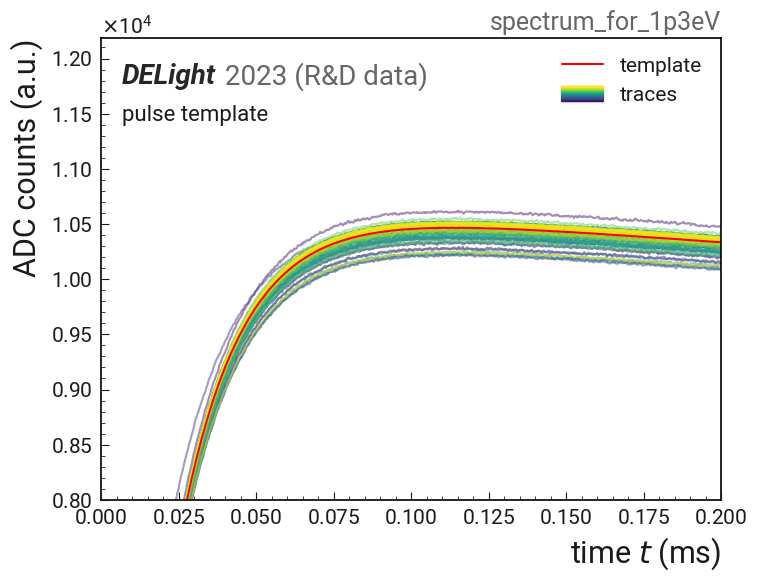

In [6]:
ev_data.plot_template(0.0, 0.2, 0.8e4)

# Template fit

fit the traces from the raw data with the template and calculate the reduced chi2 where $dof=(N_{events}-N_{param})\cdot \sigma_{baseline}$

100%|██████████████████████████████████████████████████████████████| 8654/8654 [00:35<00:00, 242.39it/s]


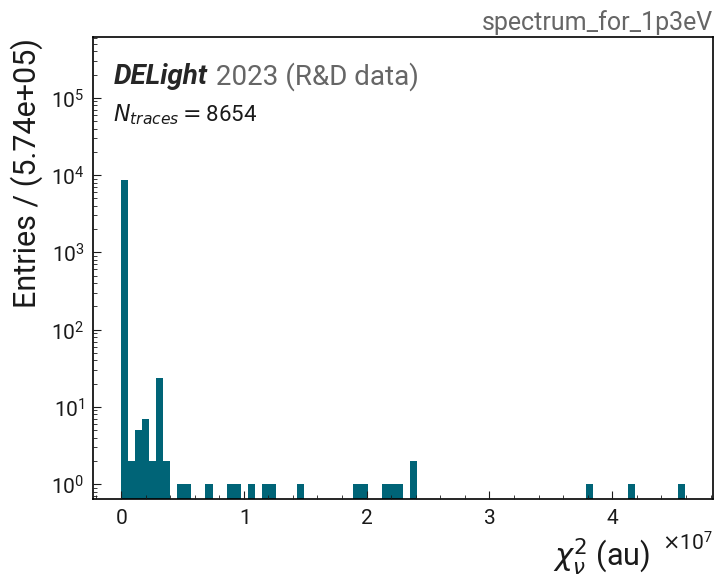

In [7]:
ev_data.fit_templates(template)

Lets have a look at some bad traces according to the template fit to check if the template fit works. This might take a few minutes to plot

In [8]:
%%time

bad_traces, _ = ev_data.query_data(**{'chi2r_templ': (1e3, 1e8)})
bad_traces = bad_traces.sort_values(by='chi2r_templ', ascending=False)

ev_data.plot_traces(bad_traces[:240].index, 
                    num_cols=5, 
                    infos=ev_data.processed_df.chi2r_templ,
                    save_path='img/chi2_templatefit_POT.pdf')

100%|████████████████████████████████████████████████████████████████| 240/240 [00:01<00:00, 166.04it/s]


CPU times: user 2min 18s, sys: 39.1 s, total: 2min 57s
Wall time: 1min 33s


# Correlation plots (before cleaning)

Now, investigate the correlations (off-diagonal) and distributions (diagonal) of the pulse attributes (reduced quantities) before and after cleaning.

Before cleaning, it is hard to identify anything, since there are way too many outliers

In [9]:
pulse_attr_corr = pulse_attr[['pulse_height', 'baseline_mean', 't_rising', 'chi2r_templ']]
pulse_attr_corr.corr().style.background_gradient(cmap='coolwarm', axis=None)

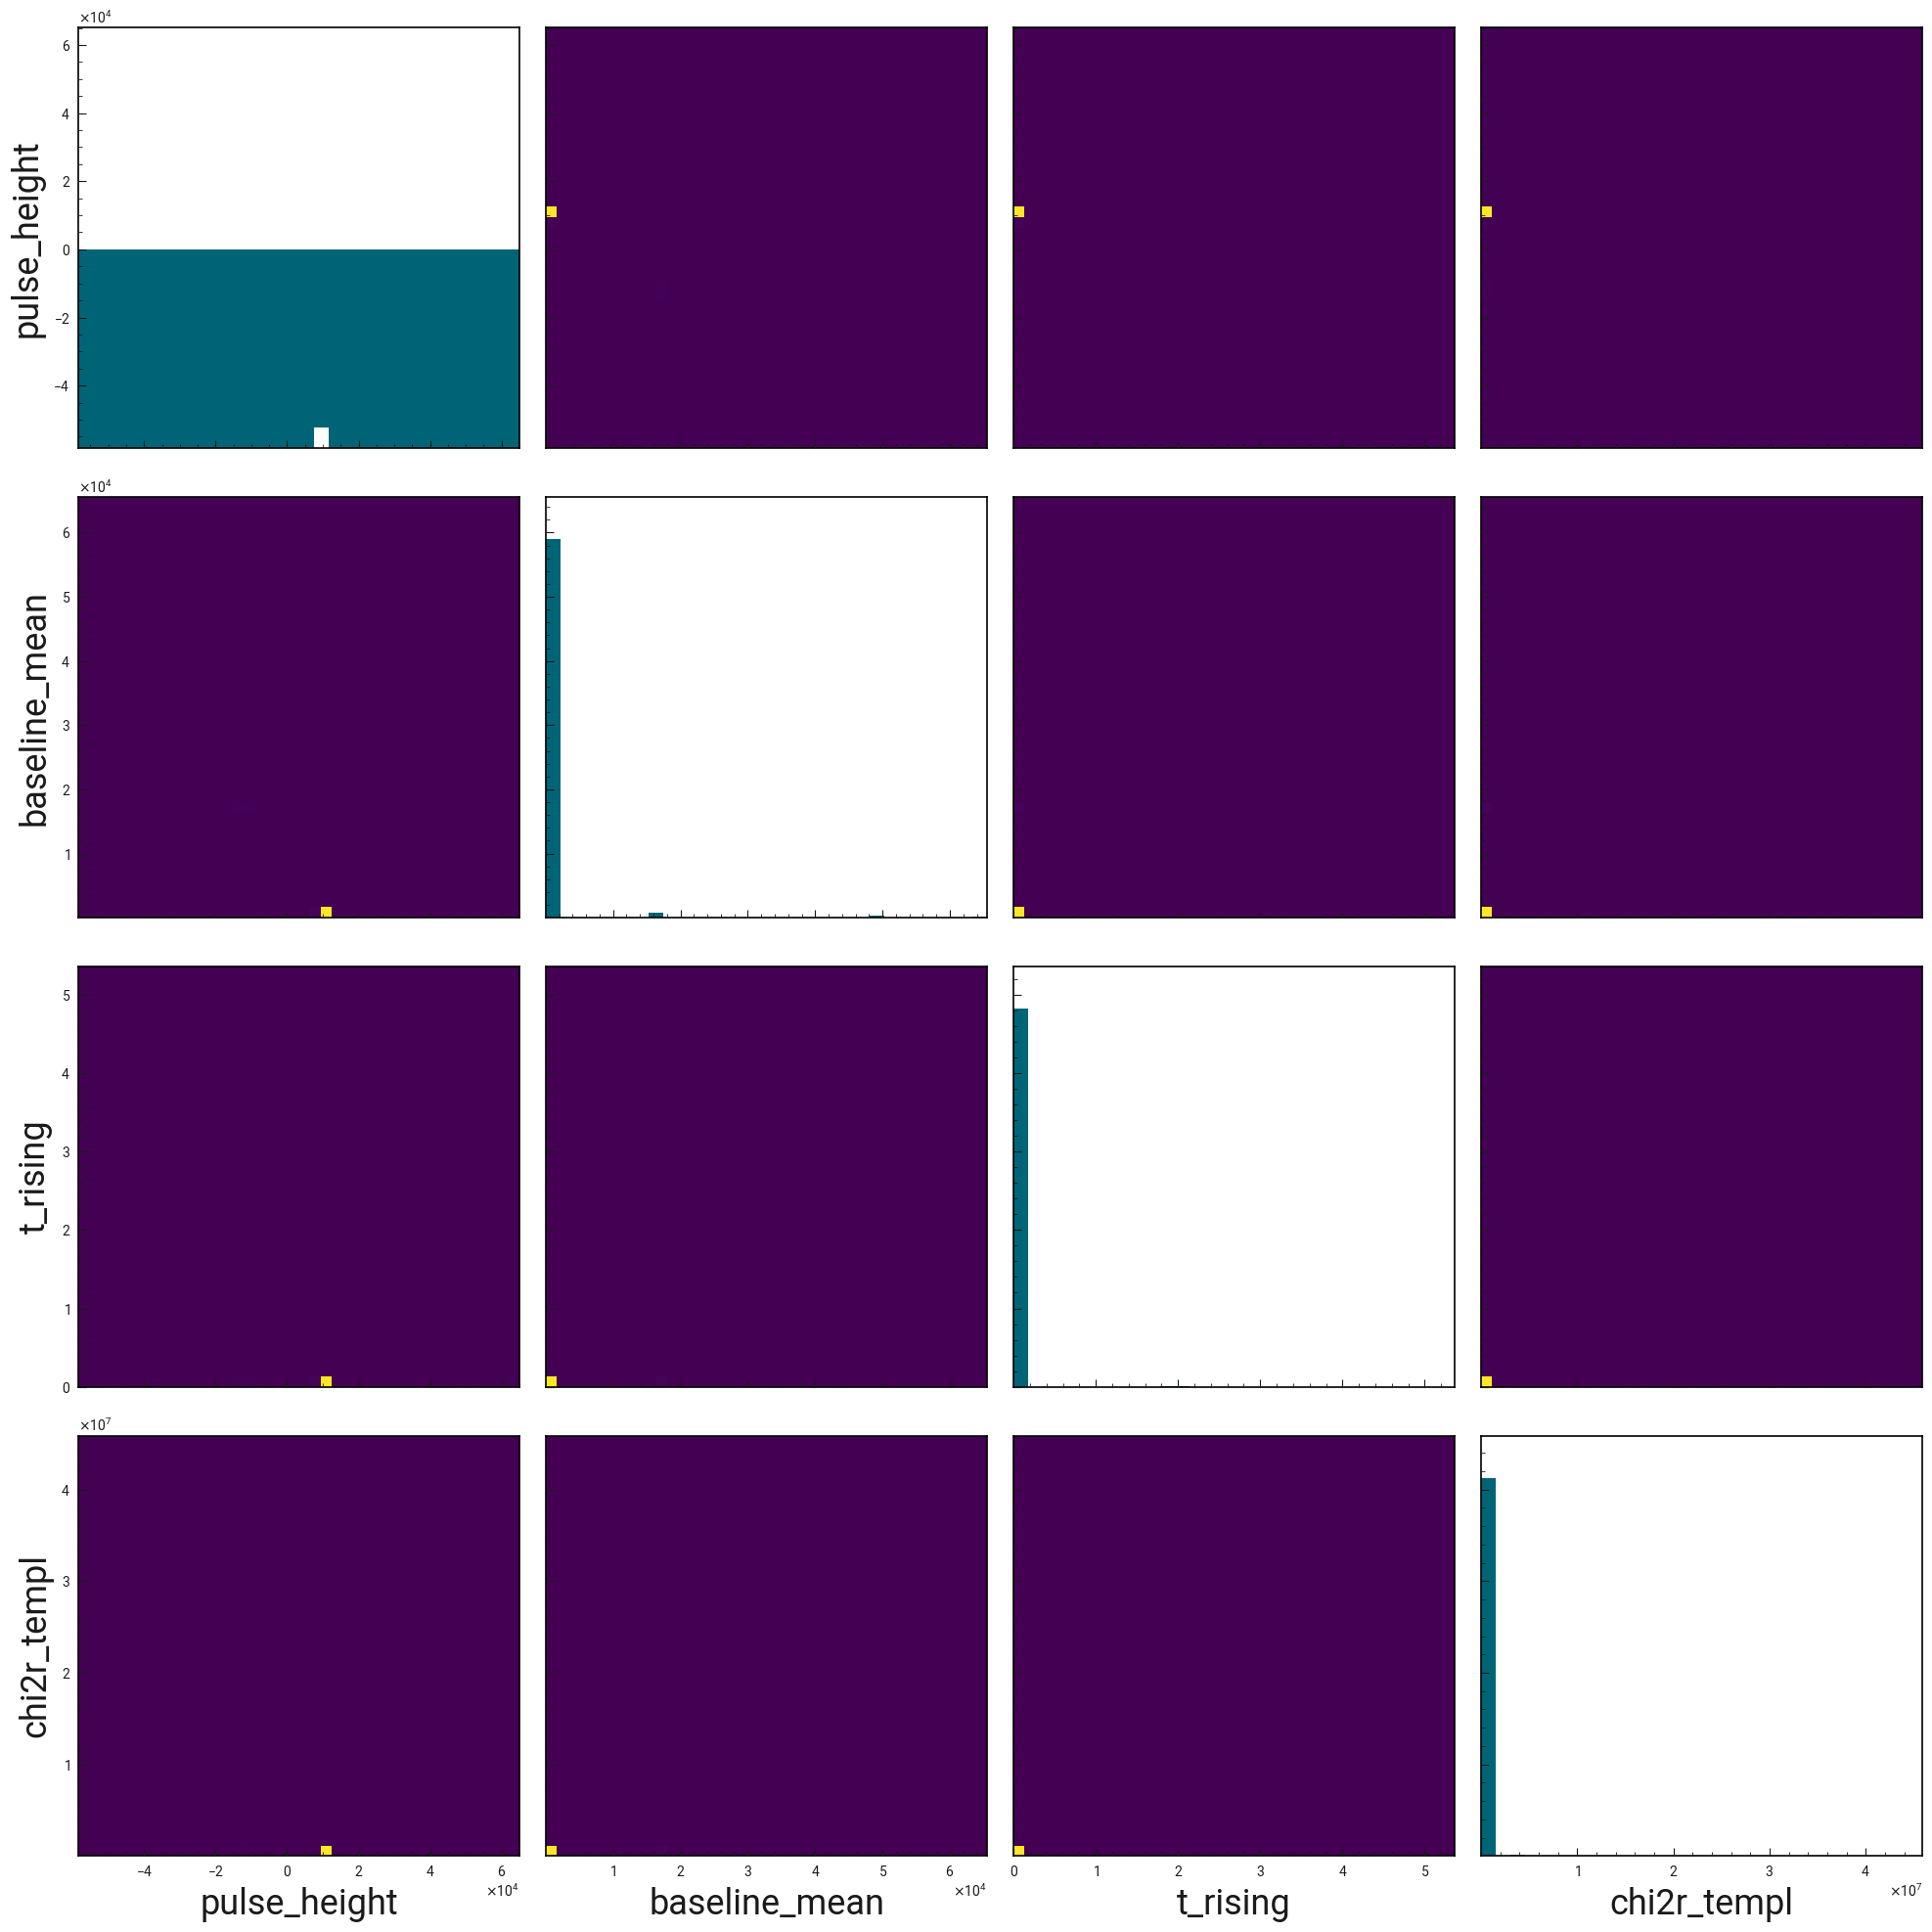

In [10]:
ev_data.plot_correlations(pulse_attr_corr)

# Clean up dataset outliers

Clean the dataset by removing all outliers from the pulse attribute distributions to obtain gauss-like distributions

In [11]:
clean_df, clean_data = ev_data.clean_dataset()

clean_df

4.50 % of original dataset removed by filters


pulse_height  peak_arg  rising_arg  baseline_mean  baseline_std  \
TraceNo                                                                    
1        10395.033209      4462        4035     128.966791      5.497584   
2        10412.858240      4463        4035     131.341760      5.541054   
3        10488.187361      4466        4035     132.412639      5.665959   
4        10395.584139      4472        4035     128.615861      5.409171   
5        11399.376456      4469        4035     128.223544      5.560980   
...               ...       ...         ...            ...           ...   
8650     11382.579678      4441        4035     132.620322      5.723889   
8651     10396.366419      4492        4035     131.133581      5.443981   
8652     10396.139157      4464        4035     133.160843      5.542639   
8653     10393.080962      4496        4034     134.319038      5.461235   
8654     10409.698513      4450        4035     145.001487      5.693536   

         t_rising  chi2r_templ  
TraceNo                         
1        0.026368     7.796616  
2        0.026368     6.174859  
3        0.026368     6.020220  
4        0.026368     6.675205  
5        0.026368     7.290674  
...           ...          ...  
8650     0.025856     7.915896  
8651     0.026368     6.202361  
8652     0.026368     6.863036  
8653     0.026368     8.407545  
8654     0.026368     6.399718  

[8265 rows x 7 columns]

now, the distributions and correlations are much cleaner

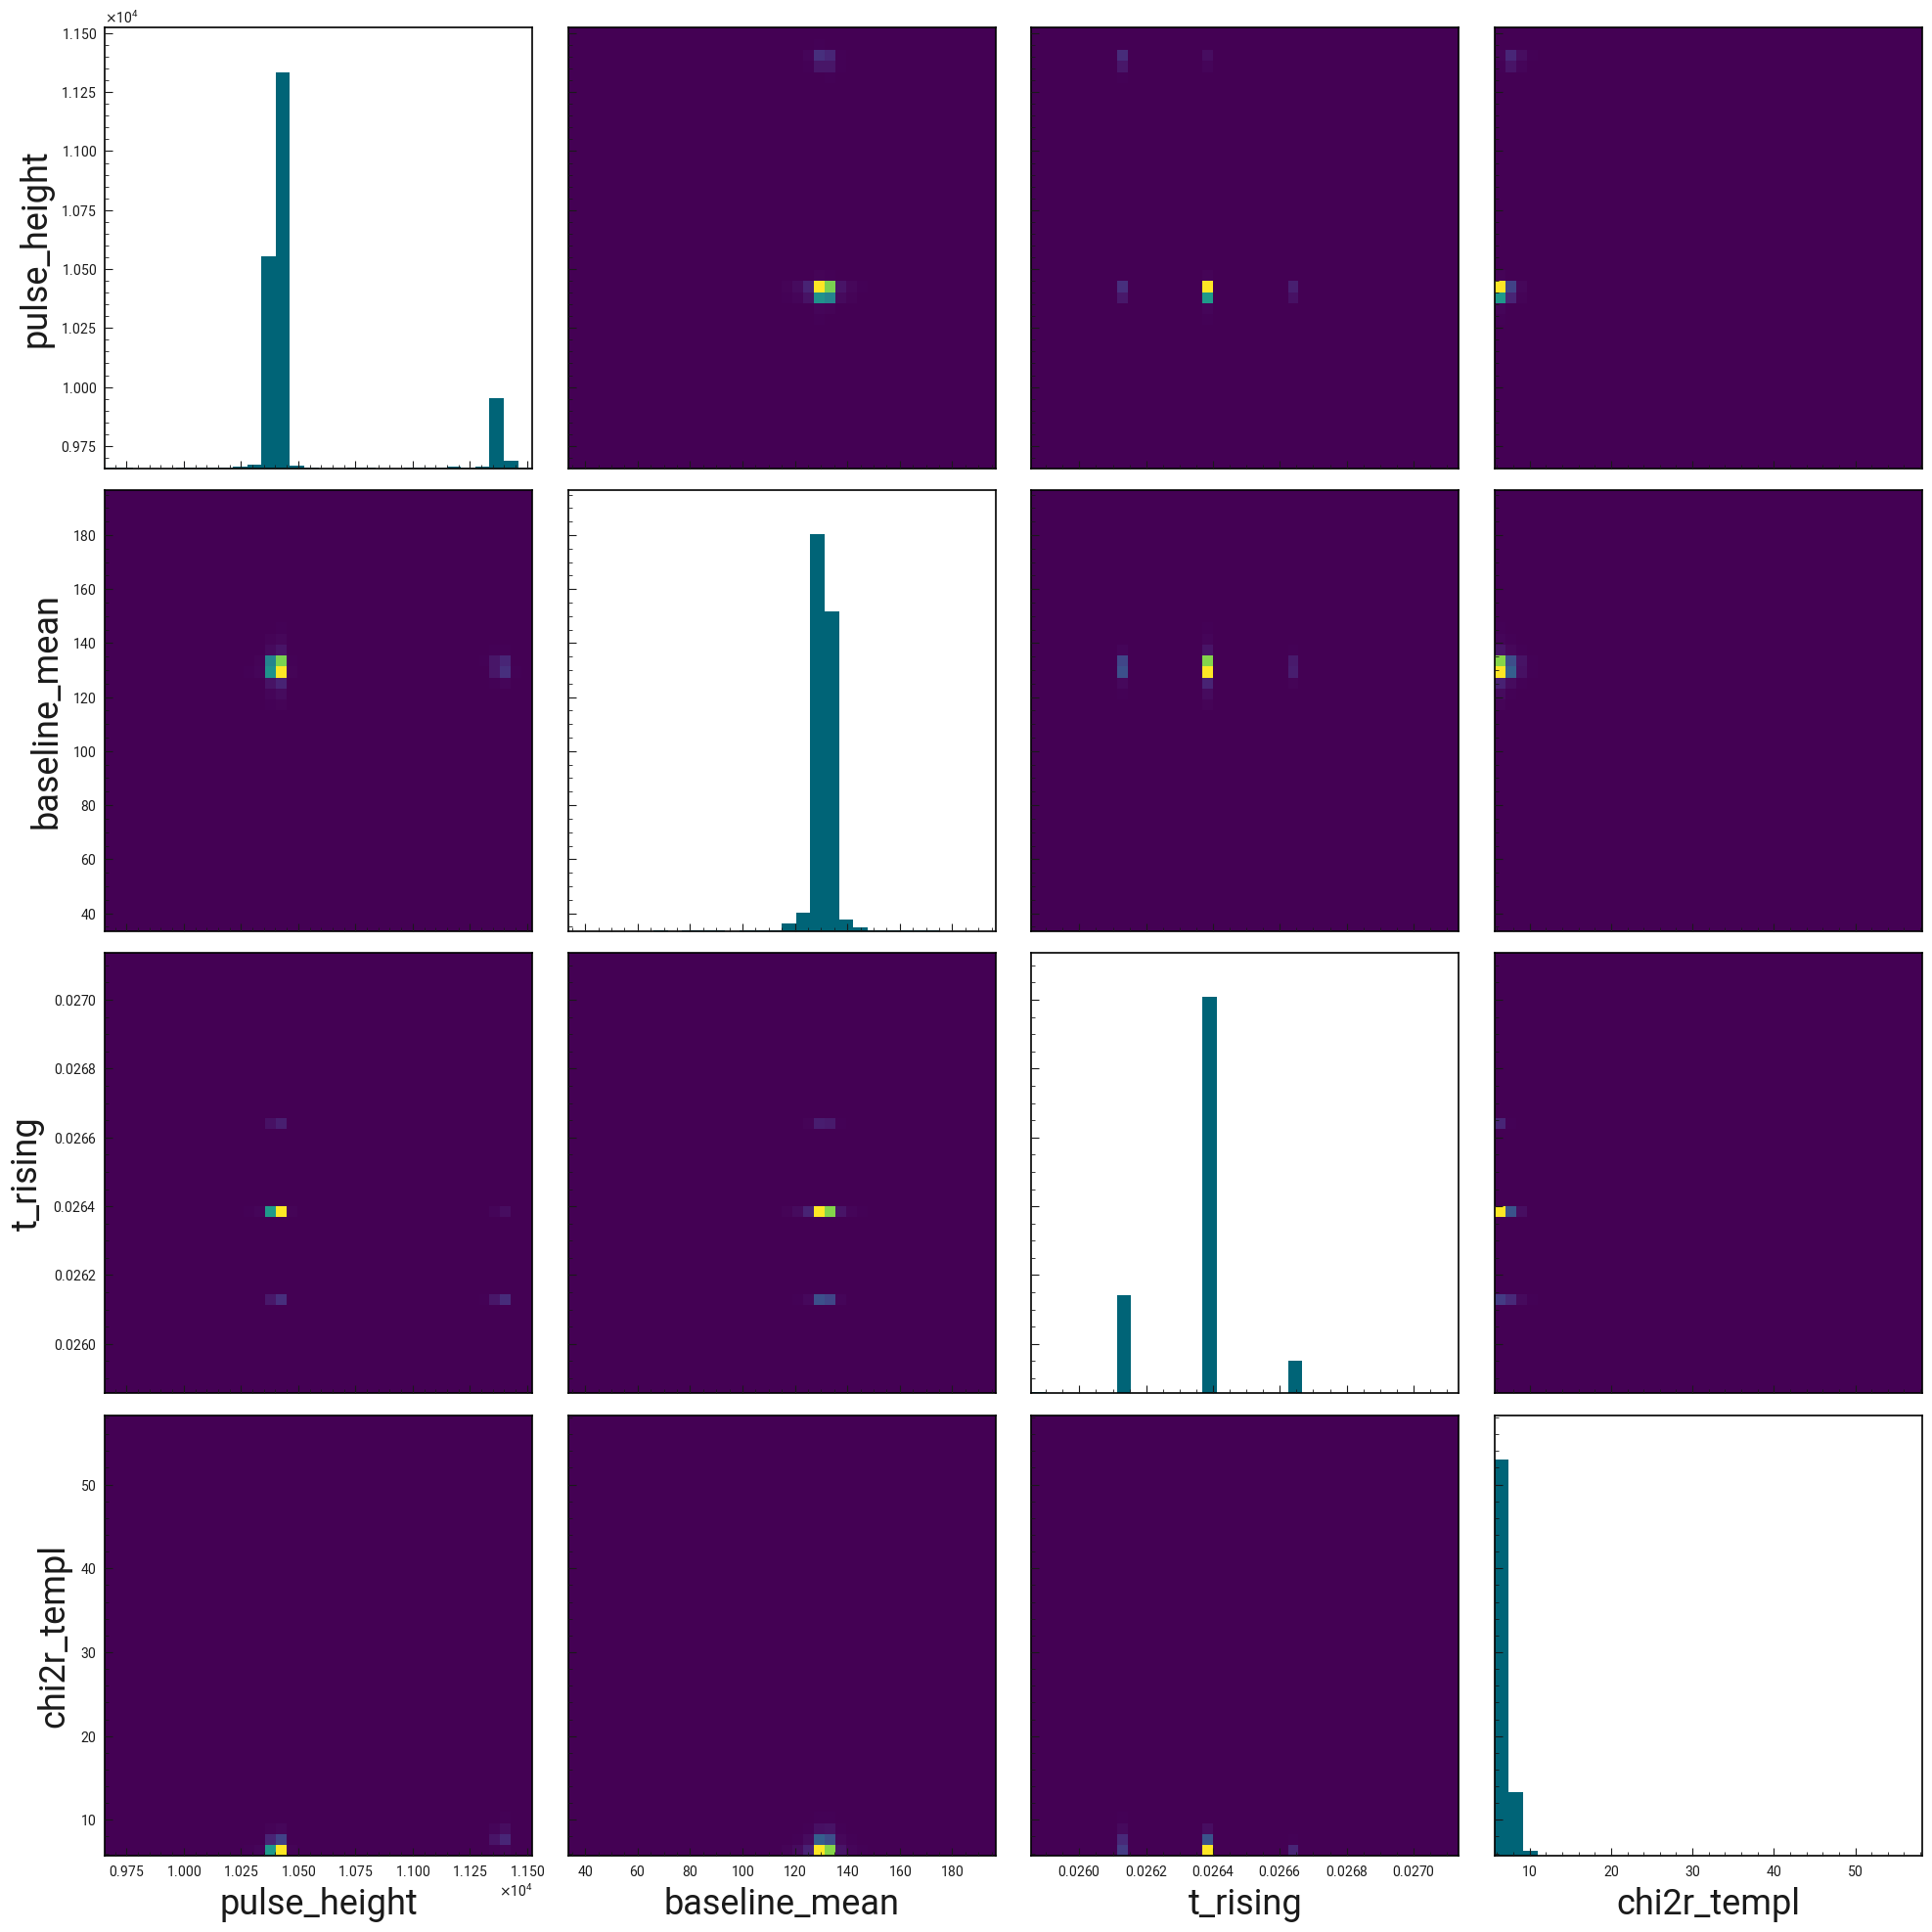

In [12]:
# Create scatter plot matrix
df = clean_df[['pulse_height', 'baseline_mean', 't_rising','chi2r_templ']]

ev_data.plot_correlations(df)
df.corr().style.background_gradient(cmap='coolwarm', axis=None)

# Energy calibration

The pulse height distribution of the detector data is correlated with the injected energy.The two peaks in the distribution correspond to the $K_\alpha$ and $K_\beta$ lines

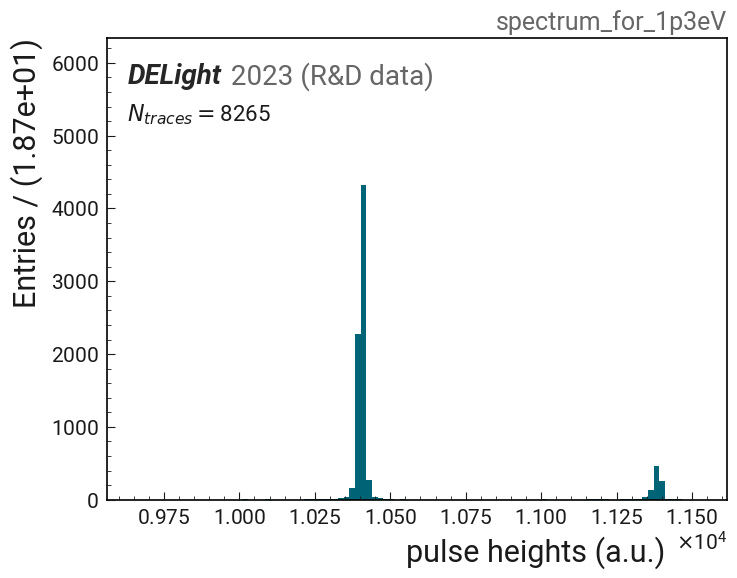

In [13]:
config={'xlabel': 'pulse heights (a.u.)',
        'xlabel_shift': True,
        'infotext': infotext(ntraces=len(clean_df))
        }

Plotter(config).hist(clean_df.pulse_height, bins=100)
plt.show()

Literature values of the K lines with data from https://journals.aps.org/pra/pdf/10.1103/PhysRevA.56.4554 p. 56 according to 

$$ f(x; x_0,\gamma,I) = \frac{I}{\left[1 + \left(\frac{x-x_0}{\gamma}\right)^2\right]} = I \left[ { \gamma^2 \over (x - x_0)^2 + \gamma^2 } \right],  $$

with energy x, peak position $x_0$, linewidth $\gamma$, and amplitude I

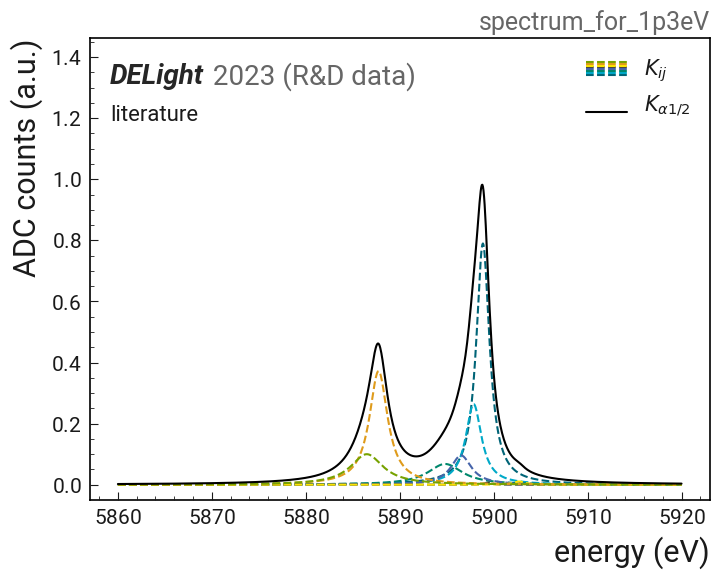

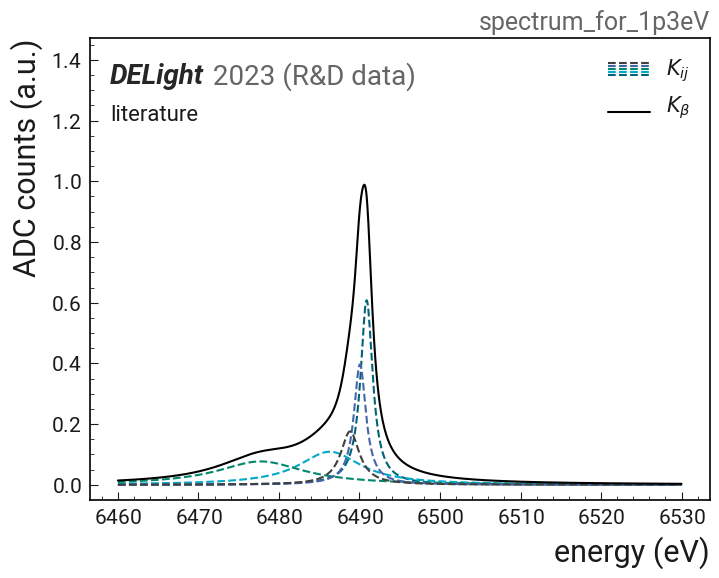

In [14]:
x = np.linspace(5860, 5920, 1000)
Klit, Kalpha_lines, Kbeta_lines = ev_data.Klines_literature(x)
ev_data.plot_Klines(x, Kalpha_lines, Klit)

x = np.linspace(6460, 6530, 1000)
Klit, Kalpha_lines, Kbeta_lines = ev_data.Klines_literature(x)
ev_data.plot_Klines(x, Kbeta_lines, Klit, labels=[r'$K_{ij}$',r'$K_{\beta}$'])

Fit literature values to pulse height distribution from data and rescale the pulse heights accordingly to obtain an energy distribution

energy = (pulse heights - 651) * 1.655


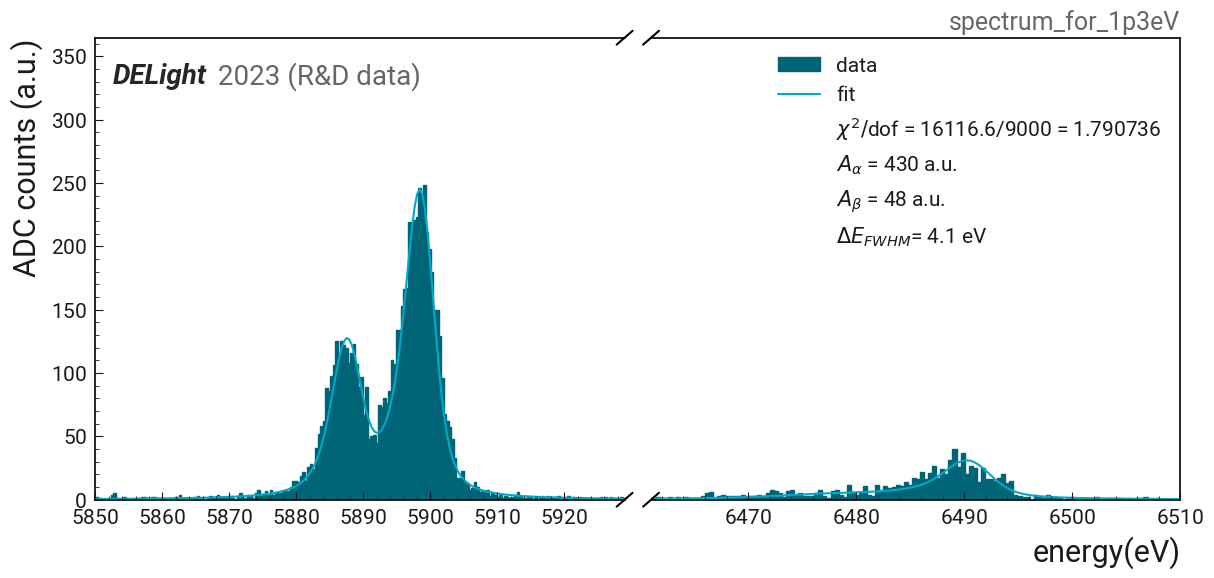

In [15]:
ev_data.energy_calculator(clean_df)

# Fake event generator

Use the template to generate fake traces with adjustable deviation from the baseline in multiples of the standard deviation of the baseline

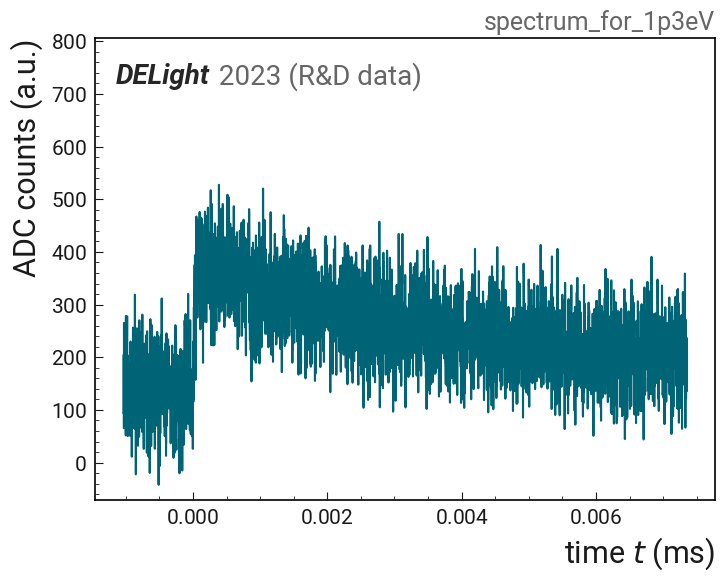

In [16]:
a = event_generator(ev_data.scopesettings, template)

Plotter().plot(a.time, a.event(sigma=4))